# Explorative Datenanalyse - Palmer Pinguine
Ausführliche Analyse des Pinguin-Datensatzes mit Fokus auf Merkmalsselektion und Modellvergleich.

In [4]:
# Benötigte Bibliotheken importieren
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from palmerpenguins import load_penguins

# Daten laden
penguins = load_penguins()


print('Datensatzgröße:', penguins.shape)


# Klassenverteilung der Spalte 'species' in Prozent anzeigen
species_distribution = penguins['species'].value_counts(normalize=True) * 100
print('\nKlassenverteilung in der Spalte "species" (in Prozent):')
print(species_distribution.round(2))
# Überprüfen der ersten Zeile
penguins.head(1)


Datensatzgröße: (344, 8)

Klassenverteilung in der Spalte "species" (in Prozent):
species
Adelie       44.19
Gentoo       36.05
Chinstrap    19.77
Name: proportion, dtype: float64


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007


In [21]:
# Überprüfen auf fehlende Werte
print('Fehlende Werte pro Spalte:')
print(penguins.isnull().sum())

# Grundlegende statistische Analyse der numerischen Merkmale
penguins.describe()

Fehlende Werte pro Spalte:
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


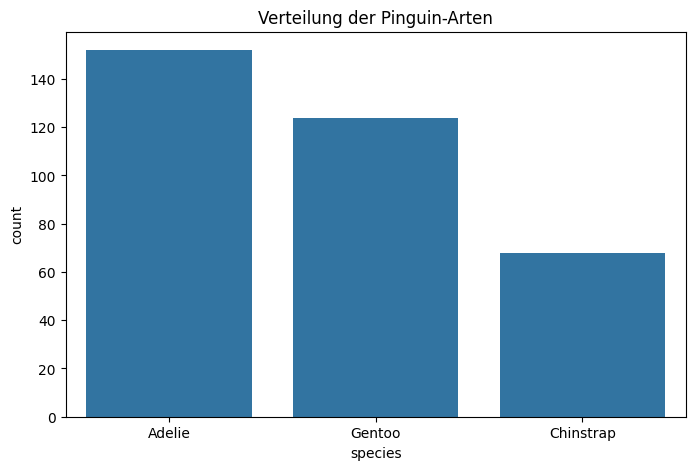

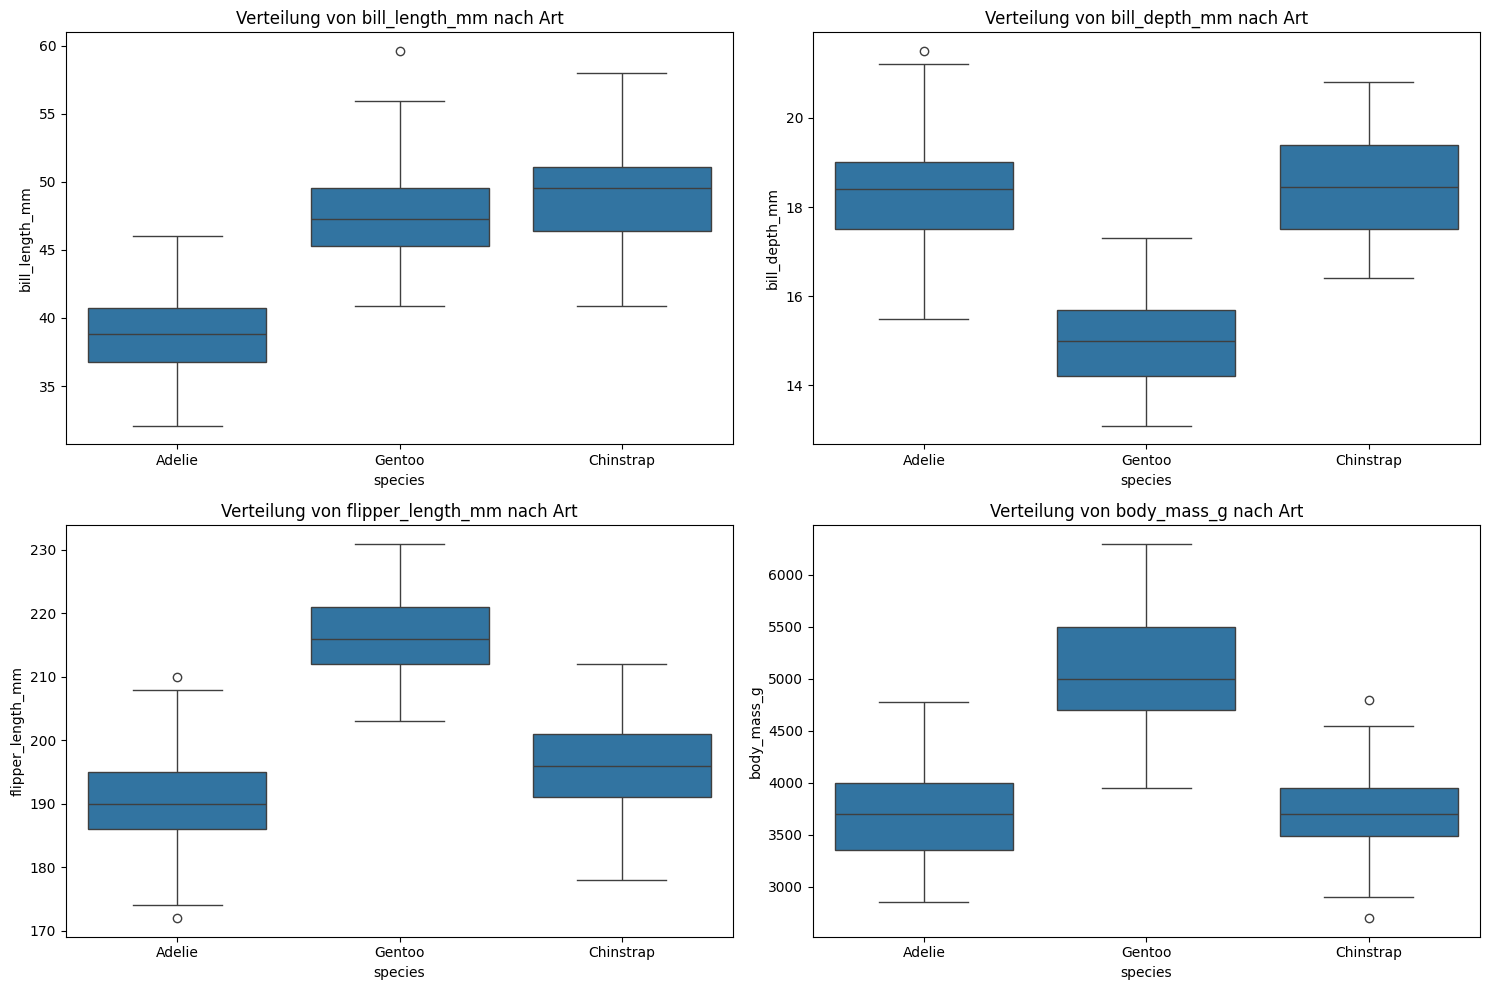

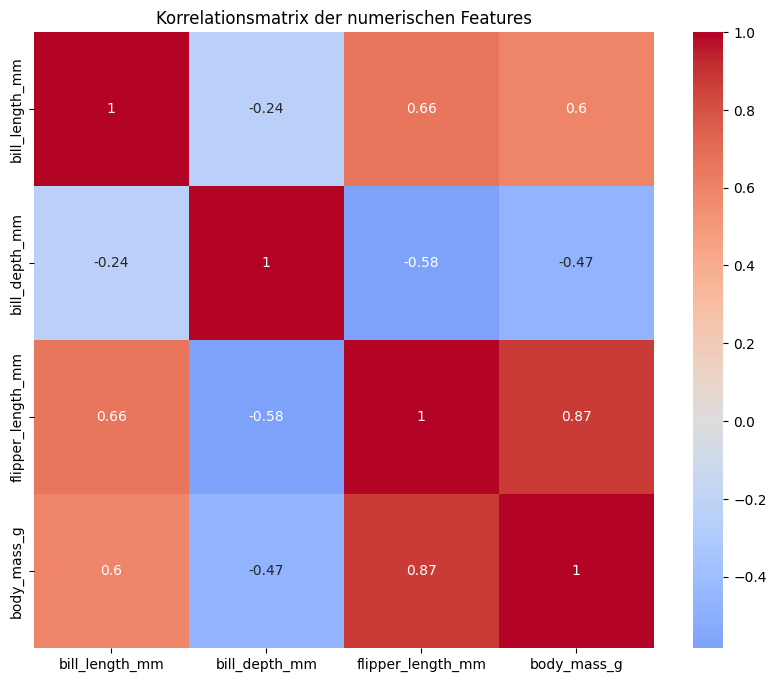

In [ ]:
# Verteilung der Zielvariable
plt.figure(figsize=(8, 5))
sns.countplot(data=penguins, x='species')
plt.title('Verteilung der Pinguin-Arten')
plt.show()

# Verteilung der numerischen Merkmale nach Art
num_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=penguins, x='species', y=feature)
    plt.title(f'Verteilung von {feature} nach Art')
plt.tight_layout()
plt.show()

# Korrelationsmatrix der numerischen Features
plt.figure(figsize=(10, 8))
sns.heatmap(penguins[num_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Korrelationsmatrix der numerischen Features')
plt.show()

In [23]:
# ANOVA-Test für Merkmalsselektion
from scipy import stats

# F-Werte und p-Werte für numerische Merkmale berechnen
anova_results = {}
for feature in num_features:
    # Entferne NaN-Werte nur für den jeweiligen Feature-Test
    feature_data = penguins[[feature, 'species']].dropna()
    groups = [group[feature].values for name, group in feature_data.groupby('species')]
    f_stat, p_val = stats.f_oneway(*groups)
    anova_results[feature] = {'F-Wert': f_stat, 'p-Wert': p_val}

# Ergebnisse als DataFrame darstellen
anova_df = pd.DataFrame(anova_results).T
anova_df = anova_df.sort_values('F-Wert', ascending=False)
print('ANOVA Testergebnisse (sortiert nach F-Wert):')
anova_df

ANOVA Testergebnisse (sortiert nach F-Wert):


,F-Wert,p-Wert
flipper_length_mm,594.801627,1.351710e-111
bill_length_mm,410.600255,2.694614e-91
bill_depth_mm,359.789149,1.507658e-84
body_mass_g,343.626275,2.892368e-82


In [11]:
# Modellvergleich mit Cross-Validation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
# import xgboost as xgb

# Features basierend auf ANOVA-Ergebnissen auswählen
selected_features = ["flipper_length_mm", "bill_length_mm", "bill_depth_mm"]

# Jetzt erst die Daten bereinigen für das finale Modelltraining
penguins_clean = penguins[selected_features + ['species']].dropna()

# Daten vorbereiten
X = penguins_clean[selected_features]
y = penguins_clean['species']

# Kodierung der Zielvariable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Pipeline und Modelle definieren (mit class_weight wo möglich)
models = {
    'Logistische Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    #'XGBoost': xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', random_state=42)
}

# F1 Macro Score für unbalancierte Klassen
f1_macro_scorer = make_scorer(f1_score, average='macro')

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    scores = cross_validate(pipe, X, y_encoded,
                          cv=5,
                          scoring=f1_macro_scorer,
                          return_train_score=False)

    results[name] = {
        'F1 Macro': np.mean(scores['test_score']),
        'Standardabweichung': np.std(scores['test_score'])
    }

# Ergebnisse als DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('F1 Macro', ascending=False)

print("Ausgewählte Features basierend auf ANOVA:")
print(selected_features)
print()
print('Modellergebnisse (sortiert nach F1 Macro Score):')
print(results_df)

Ausgewählte Features basierend auf ANOVA:
['flipper_length_mm', 'bill_length_mm', 'bill_depth_mm']

Modellergebnisse (sortiert nach F1 Macro Score):
                        F1 Macro  Standardabweichung
Logistische Regression  0.985488            0.013703
SVM                     0.975058            0.018245
Random Forest           0.972329            0.012931


In [14]:
# Feature-Range für die ausgewählten Merkmale für Datenintegritätscheck
print("\nFeature-Range für die ausgewählten Merkmale:")
print("--------------------------------------------------")
for f in selected_features:
    s = penguins[f].dropna()
    if not s.empty:
        print(f"{f}: {s.min() * 0.75:.2f} to {s.max() * 1.25:.2f}")


Feature-Range für die ausgewählten Merkmale:
--------------------------------------------------
flipper_length_mm: 129.00 to 288.75
bill_length_mm: 24.08 to 74.50
bill_depth_mm: 9.82 to 26.88
